In [1]:
import os
import cv2
import numpy as np

# 定义图像加载函数
def load_images_from_folder(folder, img_size=(64, 64)):
    images = []
    for filename in os.listdir(folder):
        if filename.lower().endswith((".png", ".jpg", ".jpeg")):  # 检查文件格式
            img_path = os.path.join(folder, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # 以灰度图加载
            if img is not None:
                img = cv2.resize(img, img_size)  # 调整图像大小
                img = img / 255.0  # 标准化
                images.append(img)
    images = np.array(images)
    images = np.expand_dims(images, axis=-1)  # 添加通道维度
    return images

# 替换成你的图像文件夹路径
folder_path = "/mnt/data1/zhaoxinjian/zhongkai/TMLR_VISG_/pretrain/bridges"
images = load_images_from_folder(folder_path)

# 检查数据形状
print(f"加载了 {len(images)} 张图像，图像大小为：{images.shape}")

加载了 100 张图像，图像大小为：(100, 64, 64, 1)


In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models

# 获取图像形状
input_shape = images.shape[1:]

# 定义 Autoencoder 模型
input_img = layers.Input(shape=input_shape)

# 编码器
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input_img)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
encoded = layers.MaxPooling2D((2, 2), padding="same")(x)

# 解码器
x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

# 构建模型
autoencoder = models.Model(input_img, decoded)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")

# 模型结构概览
autoencoder.summary()

2024-11-11 00:36:02.719051: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-11 00:36:02.759494: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-11 00:36:02.760460: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-11 00:36:03.395787: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        36928 

2024-11-11 00:36:04.472437: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [3]:
from sklearn.model_selection import train_test_split

# 分割训练集和测试集
x_train, x_test = train_test_split(images, test_size=0.2, random_state=42)

# 训练模型
autoencoder.fit(x_train, x_train, epochs=60, batch_size=32, validation_data=(x_test, x_test))

Epoch 1/60
3/3 [==============================] - 1s 208ms/step - loss: 0.6876 - val_loss: 0.6304
Epoch 2/60
3/3 [==============================] - 0s 97ms/step - loss: 0.5944 - val_loss: 0.4923
Epoch 3/60
3/3 [==============================] - 0s 100ms/step - loss: 0.4462 - val_loss: 0.3905
Epoch 4/60
3/3 [==============================] - 0s 97ms/step - loss: 0.3987 - val_loss: 0.3996
Epoch 5/60
3/3 [==============================] - 0s 101ms/step - loss: 0.4014 - val_loss: 0.3533
Epoch 6/60
3/3 [==============================] - 0s 94ms/step - loss: 0.3478 - val_loss: 0.3114
Epoch 7/60
3/3 [==============================] - 0s 93ms/step - loss: 0.3095 - val_loss: 0.3005
Epoch 8/60
3/3 [==============================] - 0s 95ms/step - loss: 0.2970 - val_loss: 0.2740
Epoch 9/60
3/3 [==============================] - 0s 87ms/step - loss: 0.2669 - val_loss: 0.2377
Epoch 10/60
3/3 [==============================] - 0s 98ms/step - loss: 0.2397 - val_loss: 0.2194
Epoch 11/60
3/3 [=========

1/1 [==============================] - 0s 94ms/step


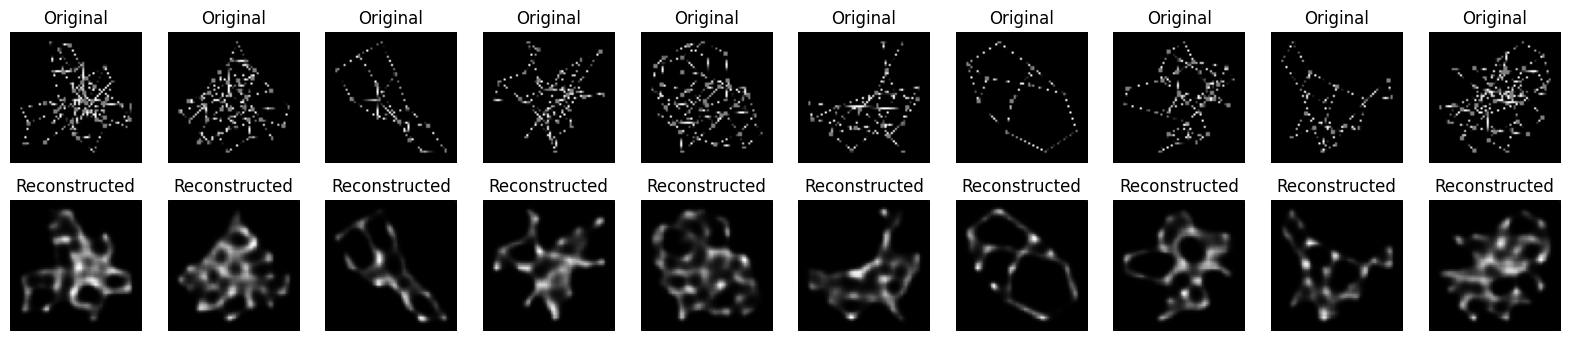

In [4]:
import matplotlib.pyplot as plt

# 预测复原图像
decoded_imgs = autoencoder.predict(x_test)

# 可视化原始图像和复原图像
n = 10  # 显示的图像数量
plt.figure(figsize=(20, 4))
for i in range(n):
    # 显示原始图像
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(input_shape[:2]), cmap="gray")
    plt.title("Original")
    plt.axis("off")

    # 显示复原图像
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(input_shape[:2]), cmap="gray")
    plt.title("Reconstructed")
    plt.axis("off")
plt.show()